# Semantic segmentation

A challenging version of general object recognition and scene understanding is to simultaneously perform recognition and accurate boundary segmentation. The basic approach to simultaneous recognition and segmentation is to formulate the problem as one of labeling every pixel in an image with its class membership.

For example, in an image that has many cars, segmentation will label all the objects as car objects. However, a separate class of models known as instance segmentation is able to label the separate instances where an object appears in an image. This kind of segmentation can be very useful in applications that are used to count the number of objects, such as counting the amount of foot traffic in a mall.

![Different kind of segmentation](https://miro.medium.com/v2/resize:fit:720/format:webp/1*SNvD04dEFIDwNAqSXLQC_g.jpeg)

The development of fully convolutional networks enabled per-pixel semantic labeling using a single neural network. Modern semantic segmentation systems are often built on architectures such as the feature pyramid network, which have top-down connections to help filter semantic information down to higher-resolution maps. For example, the Pyramid Scene Parsing Network (PSPNet) uses spatial pyramid pooling to aggregate features at various resolution levels. The Unified Perceptual Parsing network (UPerNet) uses both a feature pyramid network, and a pyramid pooling module to label image pixels not only with object categories but also materials, parts, and textures.

A notable example is SegNet, a model designed for pixel-wise, multi-class segmentation on urban road scene datasets. This model was created by researchers from the University of Cambridge’s Computer Vision Group.

![Segnet](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2023/07/segnet-AE.jpg?size=630x192&lossy=2&strip=1&webp=1)

**Having said that, most models are based on autoencoders.**

## Basic imports

In [1]:
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchinfo import summary

import torchvision
from torchvision import transforms

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import segmentation_models_pytorch as smp

/home/rvalien/miniconda3/envs/ai/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rvalien/miniconda3/envs/ai/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [9]:
torch.set_float32_matmul_precision('medium')
torch.set_default_device('cuda')
#torch.backends.cudnn.enabled = False

## Loading the dataset

In [15]:
CLASS_DICT = '../data/class_dict.csv'
class_dict = pd.read_csv(CLASS_DICT)

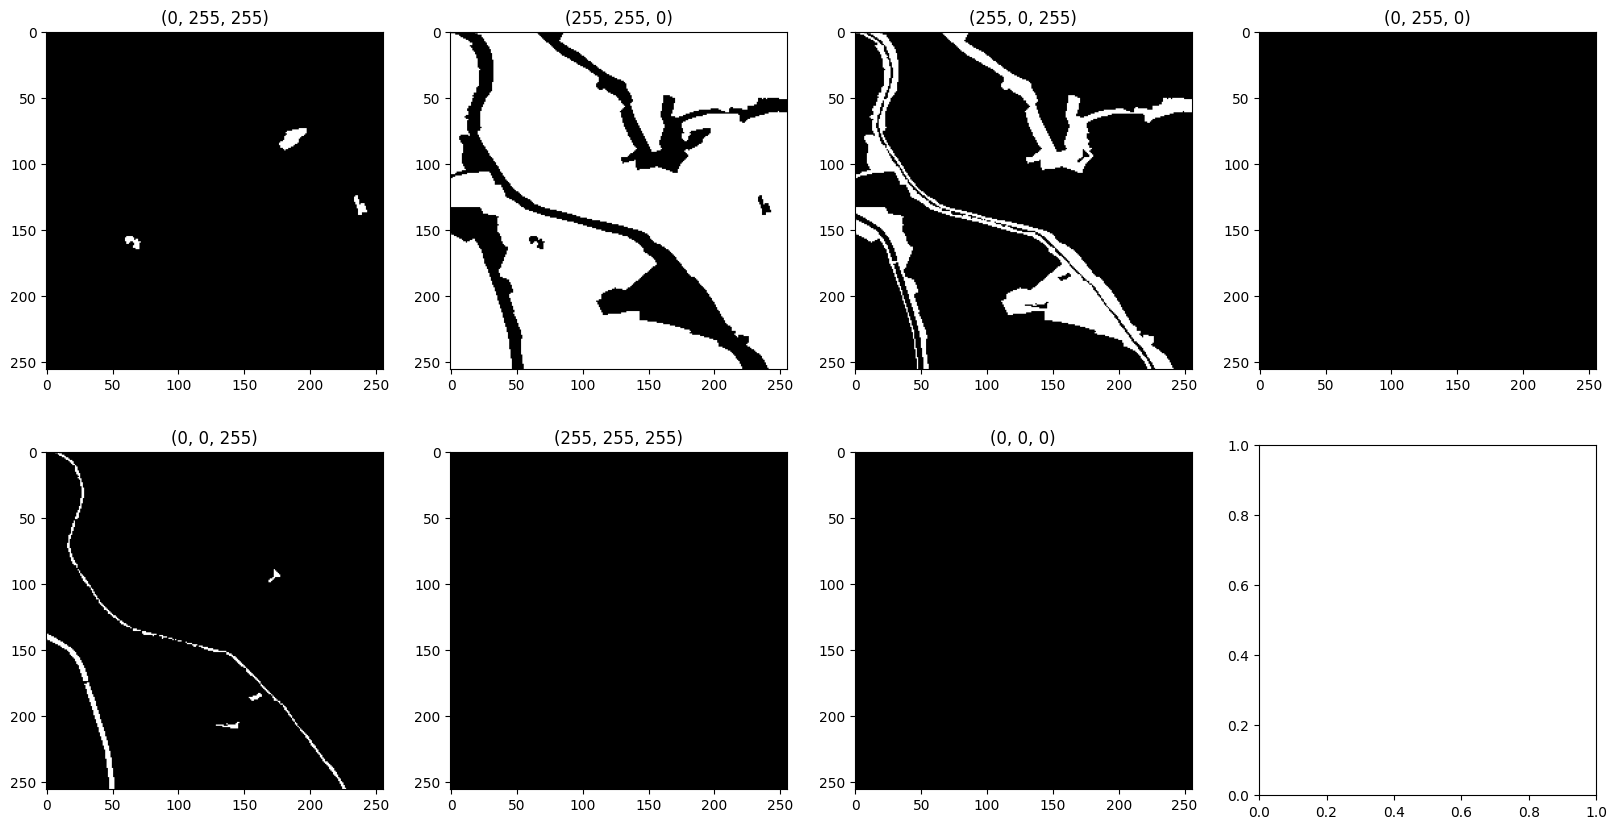

In [3]:
mask_image = cv2.imread('../data/images/119_mask.png')
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
mask_image = cv2.resize(mask_image, (256, 256), interpolation=cv2.INTER_NEAREST)

h, w, c = mask_image.shape
mask = np.reshape(mask_image, (h*w, c))
mask_colors = np.unique(mask, axis=0)

mask_tensor = np.zeros((7, h, w), dtype=np.uint8)

f, axes = plt.subplots(2, 4, figsize=(20, 10))

for i in range(7):
    row = i // 4
    col = i % 4

    color = class_dict.loc[i, 'r'], class_dict.loc[i, 'g'], class_dict.loc[i, 'b']

    mask_class = np.copy(mask_image)    
    mask_class = cv2.cvtColor(mask_class, cv2.COLOR_RGB2GRAY)

    filter = np.any(mask_image != color, axis=-1) 
    
    mask_class[filter] = 0
    mask_class[~filter] = 1

    mask_tensor[i] = mask_class
    
    axes[row, col].set_title(color)
    axes[row, col].imshow(mask_tensor[i], cmap='gray')

#print(mask_tensor)


(256, 256, 3)


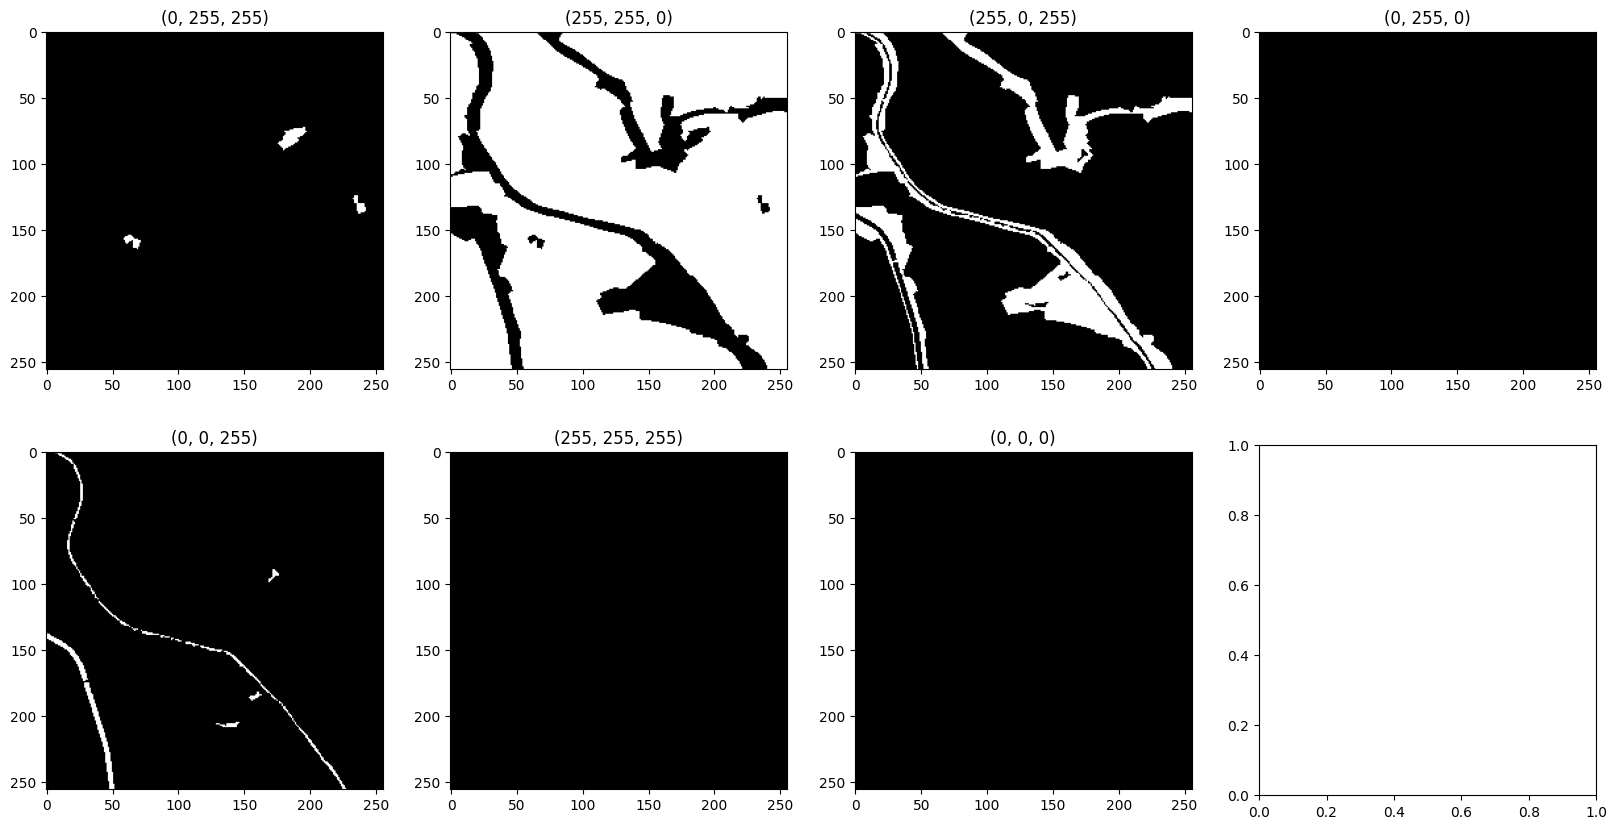

In [4]:
mask_image = Image.open('../data/images/119_mask.png').convert('RGB')
mask_array = np.array(mask_image.resize((256, 256), Image.NEAREST))

print(mask_array.shape)
h, w, c = mask_array.shape
mask = np.reshape(mask_array, (h*w, c))
mask_colors = np.unique(mask, axis=0)

mask_tensor = np.zeros((7, h, w), dtype=np.uint8)

f, axes = plt.subplots(2, 4, figsize=(20, 10))

for i in range(7):
    row = i // 4
    col = i % 4

    color = class_dict.loc[i, 'r'], class_dict.loc[i, 'g'], class_dict.loc[i, 'b']
    
    mask_class = ImageOps.grayscale(mask_image)
    mask_class = np.array(mask_class.resize((256, 256), Image.NEAREST))

    filter = np.any(mask_array != color, axis=-1) 
    
    mask_class[filter] = 0
    mask_class[~filter] = 1

    mask_tensor[i] = mask_class
    
    axes[row, col].set_title(color)
    axes[row, col].imshow(mask_tensor[i], cmap='gray')

In [6]:
image_paths = []
mask_paths = []
labels = []
with open('../data/meta.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        image_paths.append(row[0])
        mask_paths.append(row[1])
        labels.append(row[2])

for i, m, l in zip(image_paths, mask_paths, labels):
    print(i, m, l)  

../data/images\100694_sat.jpg ../data/images\100694_mask.png [2, 1]
../data/images\102122_sat.jpg ../data/images\102122_mask.png [4, 2, 1]
../data/images\10233_sat.jpg ../data/images\10233_mask.png [4, 0, 1]
../data/images\103665_sat.jpg ../data/images\103665_mask.png [4, 2, 1]
../data/images\103730_sat.jpg ../data/images\103730_mask.png [0, 2, 1]
../data/images\104113_sat.jpg ../data/images\104113_mask.png [6, 0, 2, 1, 5]
../data/images\10452_sat.jpg ../data/images\10452_mask.png [4, 3, 0, 2, 1]
../data/images\10901_sat.jpg ../data/images\10901_mask.png [4, 0, 5]
../data/images\111335_sat.jpg ../data/images\111335_mask.png [4, 3, 2, 1, 5]
../data/images\114433_sat.jpg ../data/images\114433_mask.png [3, 2, 1, 5]
../data/images\114473_sat.jpg ../data/images\114473_mask.png [3, 2, 1, 5]
../data/images\114577_sat.jpg ../data/images\114577_mask.png [4, 0, 5]
../data/images\115444_sat.jpg ../data/images\115444_mask.png [4, 0, 1]
../data/images\119012_sat.jpg ../data/images\119012_mask.png [

In [7]:
classes = []
colors = []

with open('../data/class_dict.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        classes.append(row[0])
        color = int(row[1]), int(row[2]), int(row[3])
        colors.append(color)

for c, col in zip(classes, colors):
    print(c, col)

urban_land (0, 255, 255)
agriculture_land (255, 255, 0)
rangeland (255, 0, 255)
forest_land (0, 255, 0)
water (0, 0, 255)
barren_land (255, 255, 255)
unknown (0, 0, 0)


In [5]:
class DeepGlobeDataset(Dataset):
    def __init__(self, annotations_file, class_file, transform=None):
        self.annotations = self.readAnnotations(annotations_file)
        self.transform = transform
        self.class_dict = self.readClasses(class_file)

    def readClasses(self, path):
        classes = []
        colors = []
        with open(path, 'r') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                classes.append(row[0])
                color = int(row[1]), int(row[2]), int(row[3])
                colors.append(color)
        
        return dict(classes=classes, colors=colors)

    def readAnnotations(self, path):
        image_paths = []
        mask_paths = []
        labels = []
        with open(path, 'r') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                image_paths.append(row[0])
                mask_paths.append(row[1])
                labels.append(row[2])

        return dict(images=image_paths, masks=mask_paths, labels=labels)

    def __len__(self):
        return len(self.annotations['images'])

    def _split_mask(self, mask_image):
        #mask_image = mask_image.transpose(0, 2)

        mask_array = np.array(mask_image.resize((256, 256), Image.NEAREST))
        
        h, w, _ = mask_array.shape
        mask_tensor = np.zeros((7, h, w), dtype=np.uint8)

        for i in range(7):
            color = self.class_dict['colors'][i]
            
            mask_class = mask_image.resize((256, 256), Image.NEAREST)
            mask_class = np.array(ImageOps.grayscale(mask_class))

            filter = np.any(mask_array != color, axis=-1) 
    
            mask_class[filter] = 0
            mask_class[~filter] = 1

            mask_tensor[i] = mask_class

        return mask_tensor

    def __getitem__(self, idx):
        img_path = self.annotations['images'][idx]
        img_mask = self.annotations['masks'][idx]
        img_classes = self.annotations['labels'][idx]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(img_mask).convert('RGB')
        masks_hot = None
        masks = None

        if self.transform:
            image = self.transform(image)
            masks_hot = torch.from_numpy(self._split_mask(mask))
            masks = torch.argmax(masks_hot, dim=0)
            mask = self.transform(mask)

        return dict(image=image, mask=mask, masks=masks, masks_hot=masks_hot, labels=img_classes)

In [9]:
class DeepGlobeDataset(Dataset):
    def __init__(self, annotations_file, class_dict, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform
        self.class_dict  = class_dict

    def __len__(self):
        return len(self.annotations)

    def split_mask(self, mask_image):
        #mask_image = mask_image.transpose(0, 2)
        h, w, _ = mask_image.shape
        mask_tensor = np.zeros((7, h, w), dtype=np.uint8)

        for i in range(7):
            color = self.class_dict.loc[i, 'r'], self.class_dict.loc[i, 'g'], self.class_dict.loc[i, 'b']
            
            mask_class = np.copy(mask_image)    
            mask_class = cv2.cvtColor(mask_class, cv2.COLOR_RGB2GRAY)

            filter = np.any(mask_image != color, axis=-1) 
    
            mask_class[filter] = 0
            mask_class[~filter] = 1

            mask_tensor[i] = mask_class

        return mask_tensor

    def __getitem__(self, idx):
        img_path = self.annotations.iloc[idx, 0]
        img_mask = self.annotations.iloc[idx, 1]
        img_classes = self.annotations.iloc[idx, 2]
        image = Image.open(img_path)
        mask = Image.open(img_mask)
        mask_split = cv2.imread(img_mask)
        mask_split = cv2.cvtColor(mask_split, cv2.COLOR_BGR2RGB)
        mask_split = cv2.resize(mask_split, (256, 256), interpolation=cv2.INTER_NEAREST)
        masks = torch.from_numpy(self.split_mask(mask_split))

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return dict(image=image, mask=mask, masks=masks, labels=img_classes)

In [6]:
img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor()
])

In [16]:
metadata_file = "../data/meta.csv"

In [17]:
split_percentage = 0.8

train_dataset = DeepGlobeDataset(annotations_file=metadata_file, class_file=CLASS_DICT, transform=img_transforms)

train_image_count = int(len(train_dataset) * split_percentage)
validation_image_count = len(train_dataset) - train_image_count

train_dataset, valid_dataset = random_split(train_dataset, lengths=[train_image_count, validation_image_count], generator=torch.Generator(device='cuda:0'))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, generator=torch.Generator(device='cuda:0'), num_workers=4, persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, generator=torch.Generator(device='cuda:0'), num_workers=4, persistent_workers=True)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")

Train size: 642
Valid size: 161


###  Visualizing the dataset

The dataset already has 3 elements that are noteworthy: and image array, a mask array, and a trimap array. We will use the image and mask arrays.

In [18]:
train_batch = next(iter(train_dataloader))
print(f'Image shape: {train_batch["image"].shape}')
print(f'Mask shape: {train_batch["mask"].shape}')
print(f'Masks shape: {train_batch["masks"].shape}')
print(f'Masks hot shape: {train_batch["masks_hot"].shape}')
print(f'Classes: {train_batch["labels"]}')

Image shape: torch.Size([16, 3, 256, 256])
Mask shape: torch.Size([16, 3, 256, 256])
Masks shape: torch.Size([16, 256, 256])
Masks hot shape: torch.Size([16, 7, 256, 256])
Classes: ['[4, 0, 2, 1, 5]', '[0, 1, 5]', '[6, 4, 0, 2, 1, 5]', '[0, 1, 5]', '[4, 0, 1]', '[4, 3, 0, 2, 1]', '[4, 1, 5]', '[0, 2, 1, 5]', '[4, 3, 0, 2, 1, 5]', '[4, 0, 1]', '[3, 2, 1, 5]', '[4, 0, 2, 1, 5]', '[1, 5]', '[0, 1]', '[4, 0, 2, 1, 5]', '[0, 2, 1, 5]']


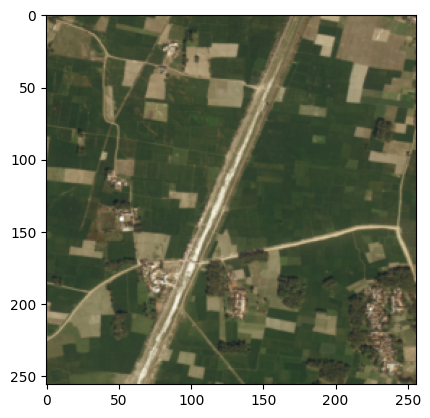

In [19]:
plt.imshow(np.transpose(train_batch['image'][0], (1, 2, 0)))

The mask is an array of black and white pixels that represent objects in the image.

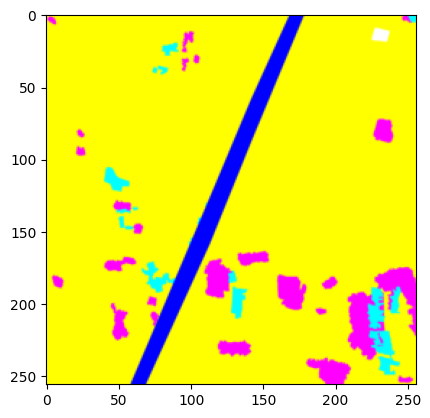

In [20]:
plt.imshow(np.transpose(train_batch['mask'][0], (1, 2, 0)))

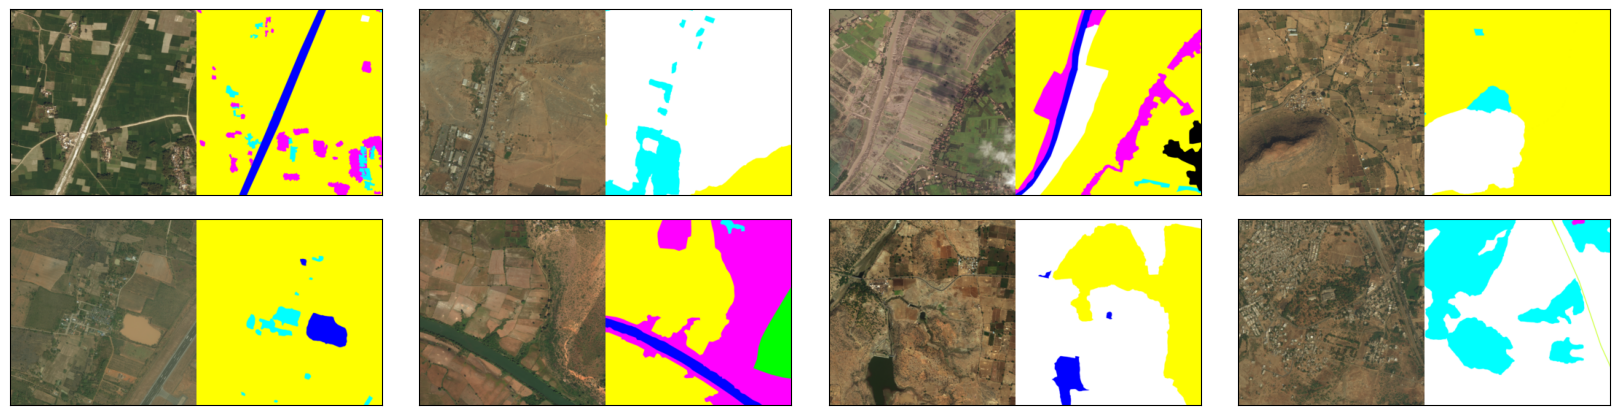

In [21]:
# Create a 5x5 subplot figure
f, ax = plt.subplots(2, 4, figsize=(20, 5))
# Adjust the layout of the subplots to avoid overlapping
f.tight_layout(pad=0.)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

# Iterate over the first 25 test images
for idx in range(8):
    # Calculate the row and column index for the subplot
    row = idx // 4
    col = idx % 4

    image = train_batch['image'][idx].numpy()
    image = image.transpose((1, 2, 0)).squeeze()
    image = (image * 255.0).astype("uint8")

    mask = train_batch['mask'][idx].numpy()
    mask = mask.transpose((1, 2, 0)).squeeze()
    mask = (mask * 255.0).astype("uint8")

    image_mask = np.zeros((256, 512, 3), dtype=np.uint8)

    image_mask[:, :256, :] = image
    image_mask[:, 256:, :] = mask

    ax[row, col].imshow(image_mask)
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

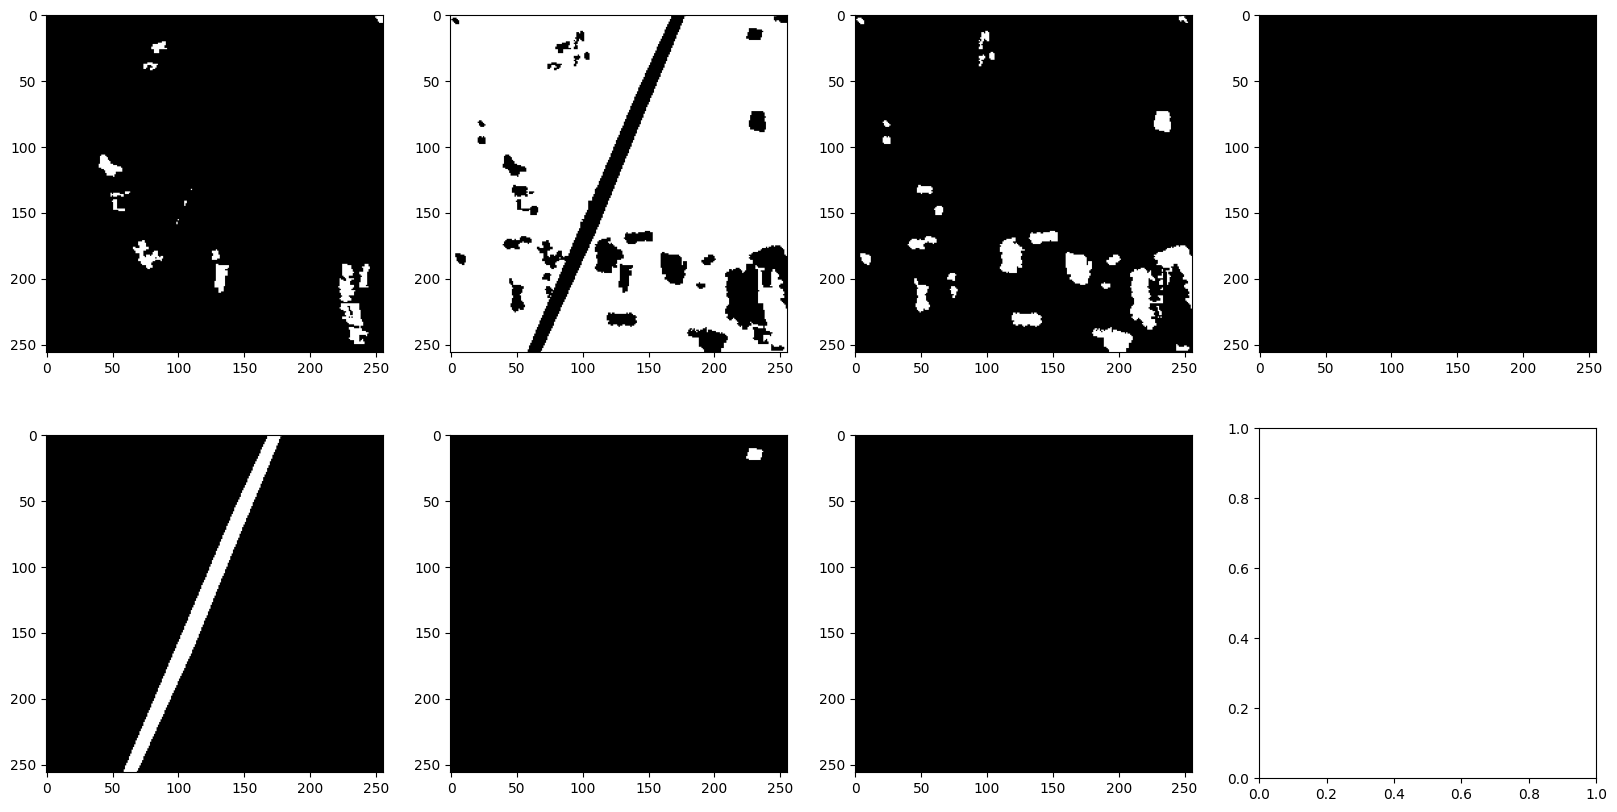

In [22]:
f, axes = plt.subplots(2, 4, figsize=(20, 10))
mask_tensor = train_batch['masks_hot'][0].numpy()

for i in range(7):
    row = i // 4
    col = i % 4
    
    axes[row, col].imshow(mask_tensor[i], cmap='gray')

ValueError: could not broadcast input array from shape (2448,2448) into shape (256,256)

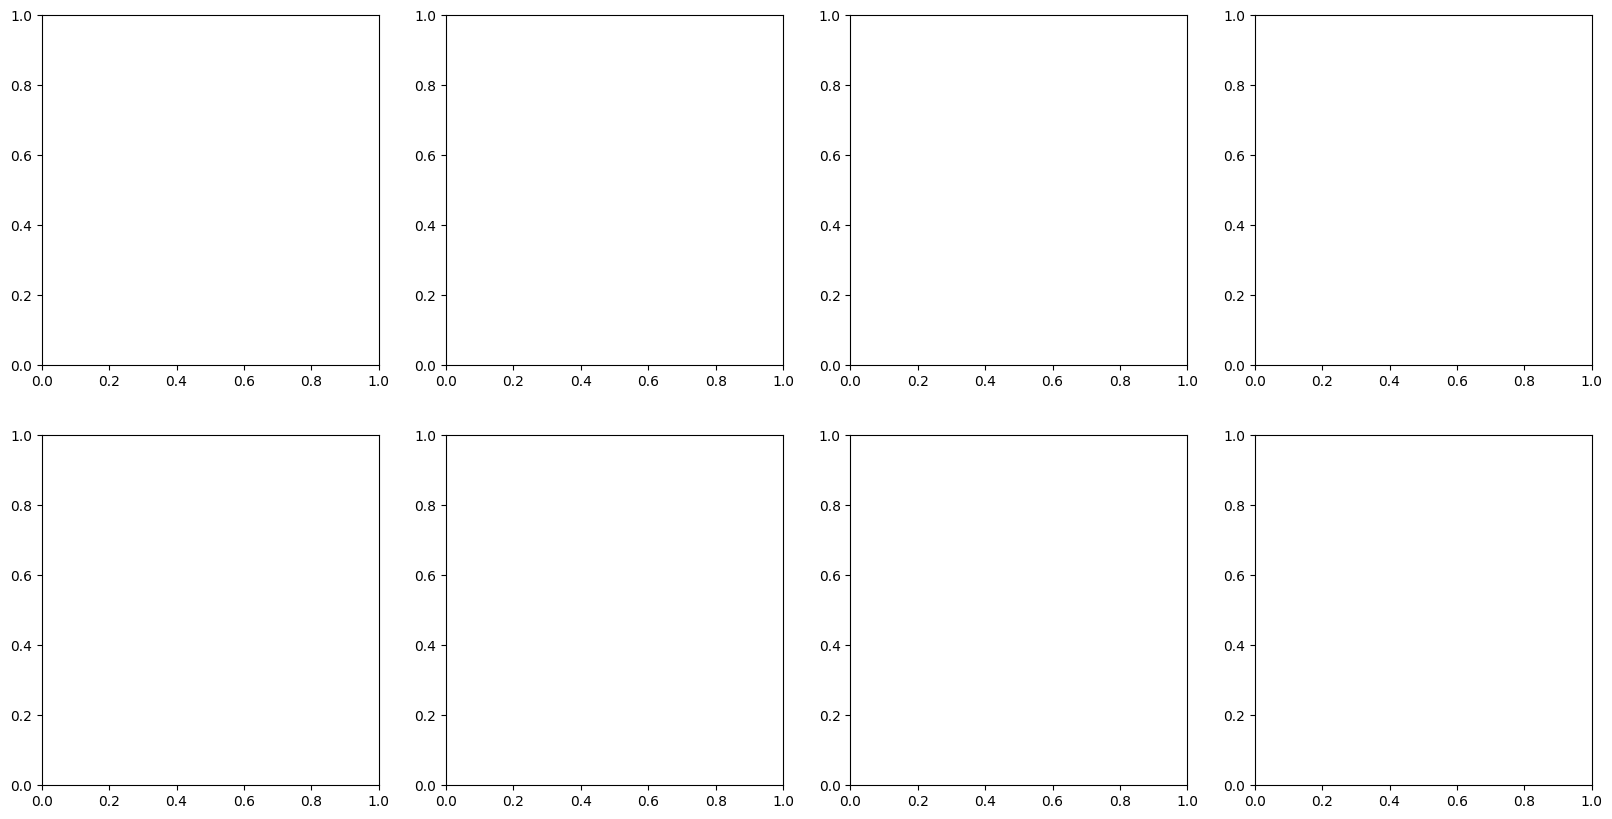

In [ ]:
f, axes = plt.subplots(2, 4, figsize=(20, 10))

for i in range(7):
    row = i // 4
    col = i % 4

    color = class_dict.loc[i, 'r'], class_dict.loc[i, 'g'], class_dict.loc[i, 'b']

    mask_class = np.copy(mask_image)    
    mask_class = cv2.cvtColor(mask_class, cv2.COLOR_RGB2GRAY)

    filter = np.any(mask_image != color, axis=-1) 
    
    mask_class[filter] = 0
    mask_class[~filter] = 1

    mask_tensor[i] = mask_class
    
    axes[row, col].set_title(color)
    axes[row, col].imshow(mask_tensor[i], cmap='gray')

## Model

We will use a class that takes a model architecture of the model, the name of the encoder, the number of input channels in the images, and the number of output classes. You can change these parameters to suit a given problem. We are introducing two concepts that are used to evaluate semantic segmentation models:

- Dice Loss: Dice loss, also known as the Sørensen-Dice coefficient, is a popular choice for image segmentation. It measures the overlap between the predicted and target segmentation masks.
- Intersection over Union (IoI): A popular metric to measure localization accuracy and compute localization errors in object detection models. It calculates the amount of overlapping between two bounding boxes, or pixel areas.


In [23]:
class DeepGlobeModel(L.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes):
        '''
            Initializes an instance of the SemanticSegmentation class.

            Parameters:
            - arch (str): The architecture of the model.
            - encoder_name (str): The name of the encoder.
            - in_channels (int): The number of input channels.
            - out_classes (int): The number of output classes.
        '''
        super().__init__()

        '''
            It is important to note that we are not using a trained encoder. To use a trained encoder, change
            The value in the encoder_weight parameter.
        '''
        self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, encoder_weights='imagenet')

        '''
           These are used to store the computed true positive, false positive, false negative and true negative 'pixels' for each image and class
        '''
        self.tp = None
        self.fp = None
        self.fn = None
        self.tn = None

        '''
            These are used to store the computed losses for each stage
        '''
        self.losses = {
            'valid': [],
            'train': [],
            'test': []
        }

        '''
            These parameters are used to normalize the input image. Models from the segmentation_models_pytorch library
            require the input image to be normalized. The mean and standard deviation values are used to normalize the image.
            The mean and standard deviation values are obtained from the get_preprocessing_params function of the encoders module.
        '''
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        '''
            Dice Loss: Dice loss, also known as the Sørensen-Dice coefficient, is a popular choice for image segmentation.
            It measures the overlap between the predicted and target segmentation masks.
        '''
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        self.out_classes = out_classes

    def forward(self, image):

        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch['image']

        assert image.ndim == 4

        #h, w = image.shape[2:]
        #assert h % 32 == 0 and w % 32 == 0

        masks = batch['masks']

        # Shape of the mask should be [batch_size, num_classes, height, width] for segmentation num_classes = 7
        assert masks.ndim == 3

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert masks.max() <= 6.0 and masks.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, masks)

        # Lets compute metrics for some threshold: first convert mask values to probabilities, then apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        '''
            We will compute IoU metric by two ways
              1. dataset-wise
              2. image-wise
            but for now we just compute true positive, false positive, false negative and
            true negative 'pixels' for each image and class
            these values will be aggregated in the end of an epoch
        '''

        pred_mask = torch.argmax(pred_mask, dim=1)
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), masks.long(), mode="multiclass", num_classes=self.out_classes)

        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn

        self.losses[stage].append(loss)

        return loss

    def shared_epoch_end(self, stage):
        # aggregate step metics
        tp = self.tp
        fp = self.fp
        fn = self.fn
        tn = self.tn

        '''
            Per image IoU means that we first calculate IoU score for each image
            and then compute mean over these scores
        '''
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        '''
            Dataset IoU means that we aggregate intersection and union over whole dataset
            and then compute IoU score. The difference between dataset_iou and per_image_iou scores
            in this particular case will not be much, however for dataset
            with "empty" images (images without target class) a large gap could be observed.
            Empty images influence a lot on per_image_iou and much less on dataset_iou.
        '''
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_loss": torch.stack(self.losses[stage]).mean(),
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True, logger=True)

    '''
        These are pytorch lightning hooks that are called during the training, validation and testing steps.
        Hooks are used to perform additional operations during these steps. In this case, we are using the hooks
        to compute the loss and metrics for each step and epoch.
    '''
    def training_step(self, batch):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.0001)

In [24]:
model = DeepGlobeModel("Unet", "timm-resnest50d", in_channels=3, out_classes=7)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /home/rvalien/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth
100%|██████████| 105M/105M [00:03<00:00, 28.2MB/s] 


## Training

In [25]:
# Early stop is a callback that is used to stop the training process when the validation loss does not improve. In this case, we are
# using the EarlyStopping callback to stop the training process when the validation loss does not improve for 3 epochs.
earlystop_callback = EarlyStopping('valid_loss', patience=3)
checkpoint_callback = ModelCheckpoint(dirpath='checkpoints/', filename='UnetResNest50d')

trainer = L.Trainer(max_epochs=15, logger=CSVLogger(save_dir="logs/", name="pets_seg-model"), callbacks=[earlystop_callback])

trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/pets_seg-model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 34.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
34.4 M    Trainable params
0         Non-trainable params
34.4 M    Total params
137.793   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/rvalien/miniconda3/envs/ai/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [26]:
# We verify the training using the validate method of the trainer object. The validate method returns the metrics for the validation dataset.
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_loss': 0.37702327966690063, 'valid_per_image_iou': 0.8630090355873108, 'valid_dataset_iou': 0.8630090355873108}]


### Visualizing training results

,step,train_dataset_iou,train_loss,train_per_image_iou,valid_dataset_iou,valid_loss,valid_per_image_iou
epoch,,,,,,,
0,40.0,0.721257,0.690876,0.721257,0.721257,0.569100,0.721257
1,81.0,0.795384,0.607763,0.795384,0.795384,0.528243,0.795384
2,122.0,0.830921,0.560860,0.830921,0.830921,0.492026,0.830921
3,163.0,0.870266,0.528546,0.870266,0.870266,0.468334,0.870266
4,204.0,0.864679,0.503749,0.864679,0.864679,0.455263,0.864679
5,245.0,0.704026,0.484207,0.704026,0.704026,0.446079,0.704026
6,286.0,0.874090,0.466355,0.874090,0.874090,0.431512,0.874090
7,327.0,0.807590,0.450059,0.807590,0.807590,0.423441,0.807590
8,368.0,0.829312,0.435745,0.829312,0.829312,0.416217,0.829312


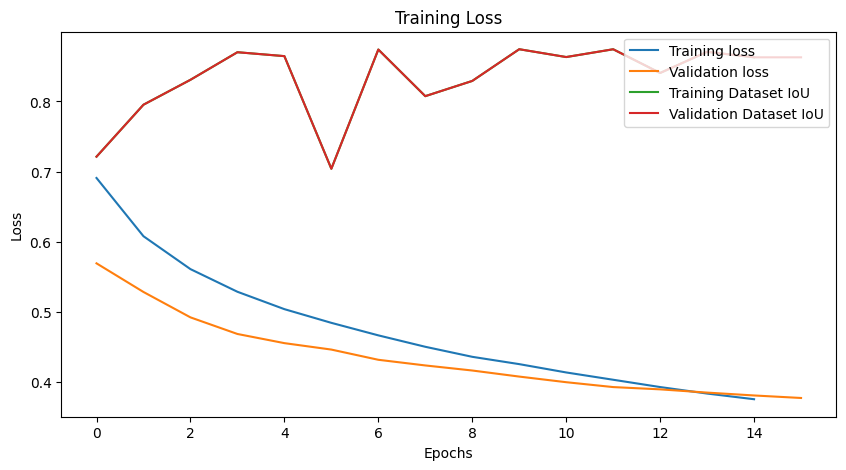

In [27]:
# Read the metrics.csv file generated by the PyTorch Lightning logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Group the metrics by epoch and compute the mean loss for each epoch
df_epochs = metrics.groupby('epoch').mean()

display(df_epochs)

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
ax.plot(df_epochs['train_loss'], label="Training loss")
ax.plot(df_epochs['valid_loss'], label="Validation loss")

ax.plot(df_epochs['train_dataset_iou'], label="Training Dataset IoU")
ax.plot(df_epochs['valid_dataset_iou'], label="Validation Dataset IoU")

# Plot the training loss over epochs
# Plot the validation loss over epochs
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

In [72]:
class_dict

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


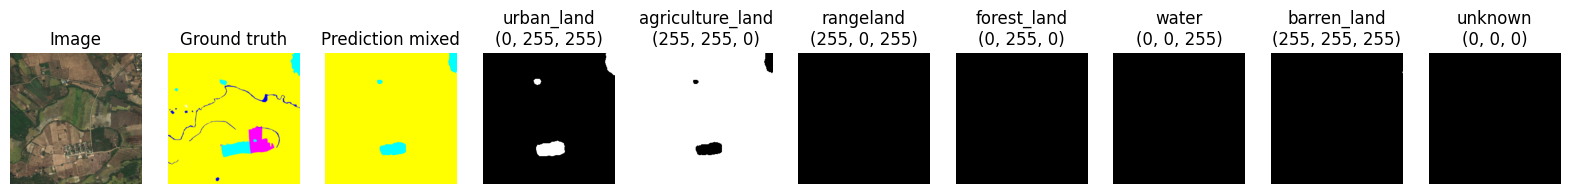

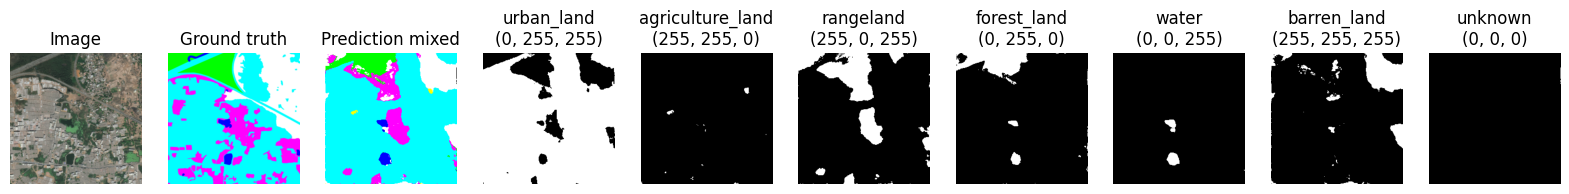

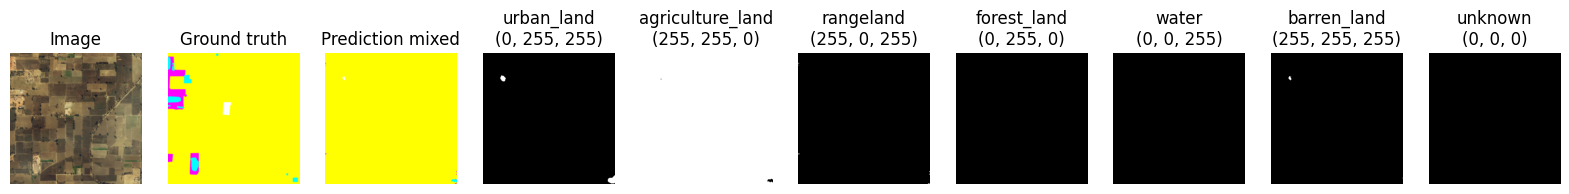

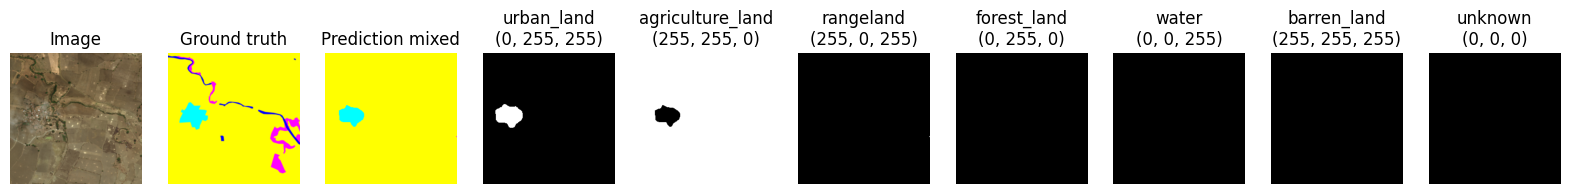

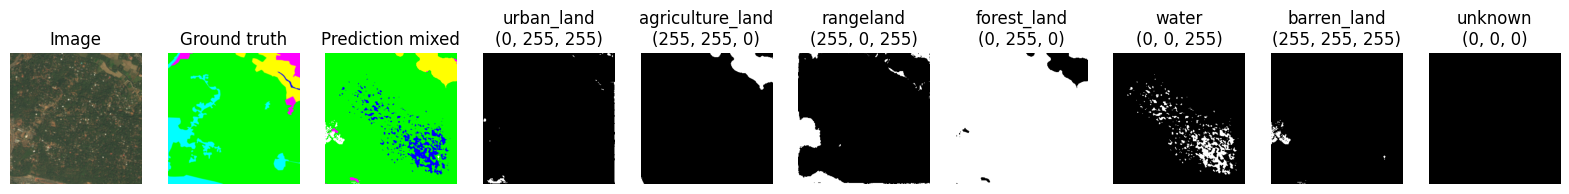

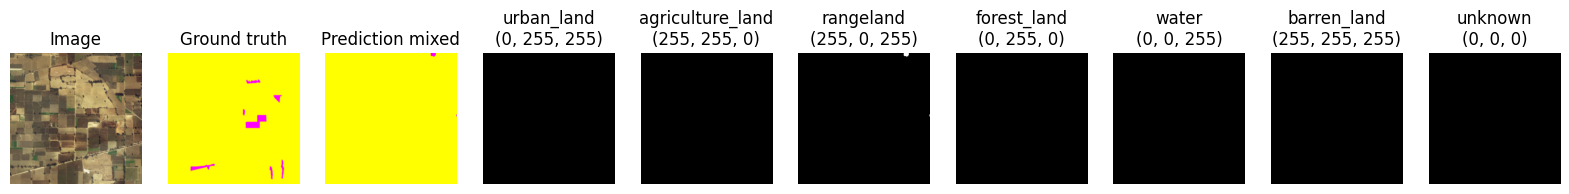

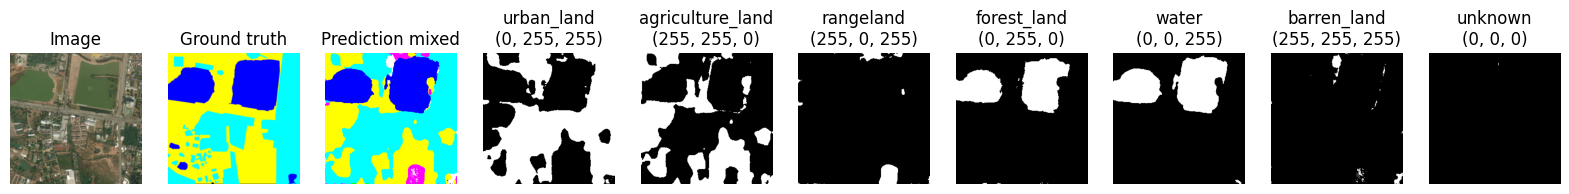

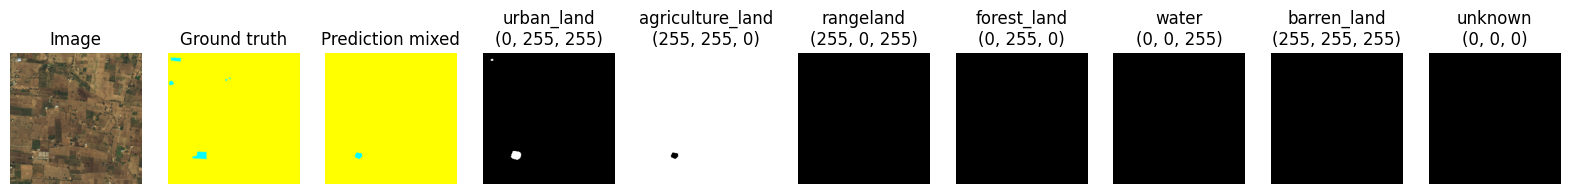

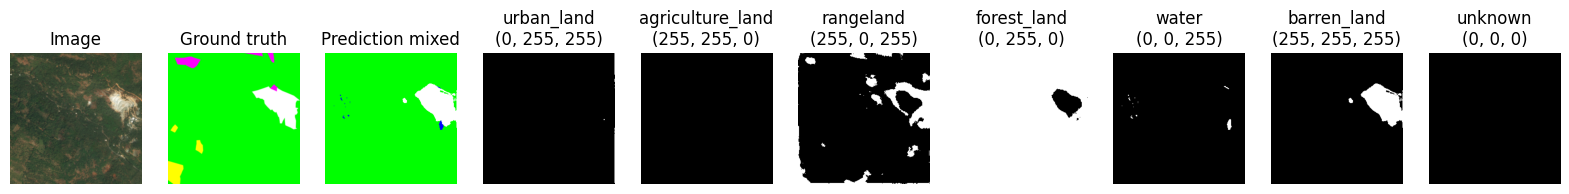

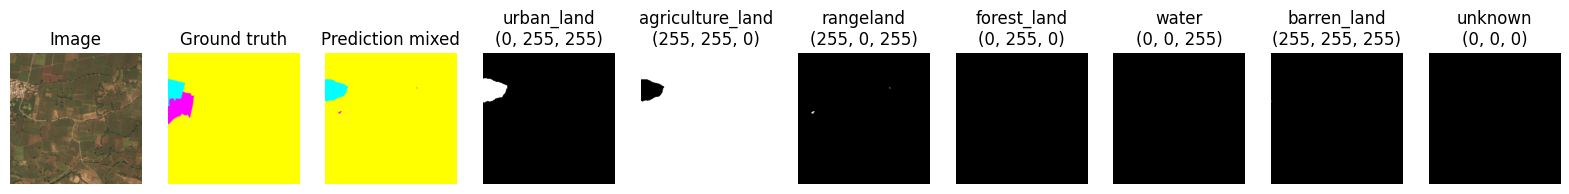

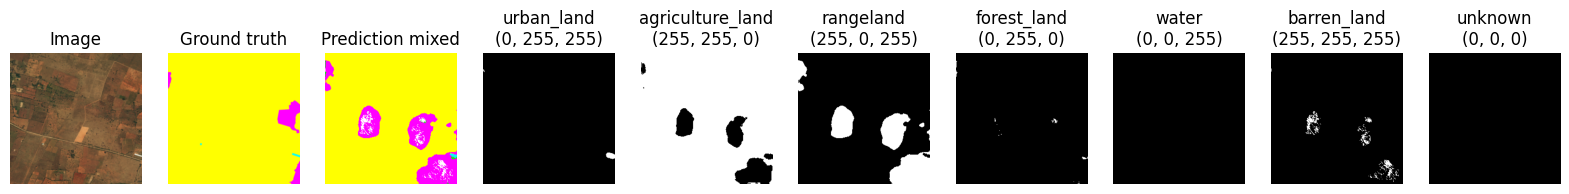

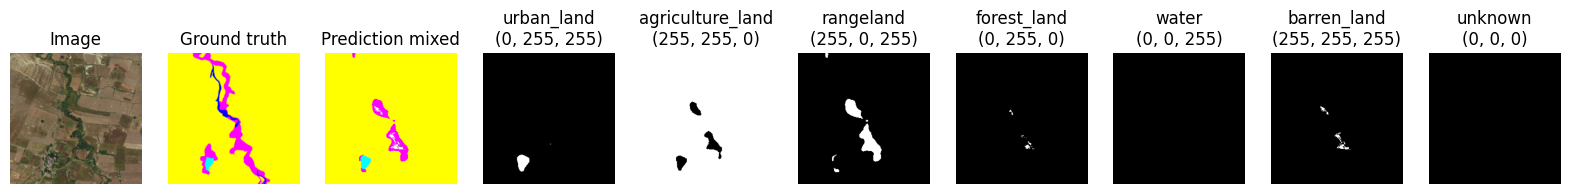

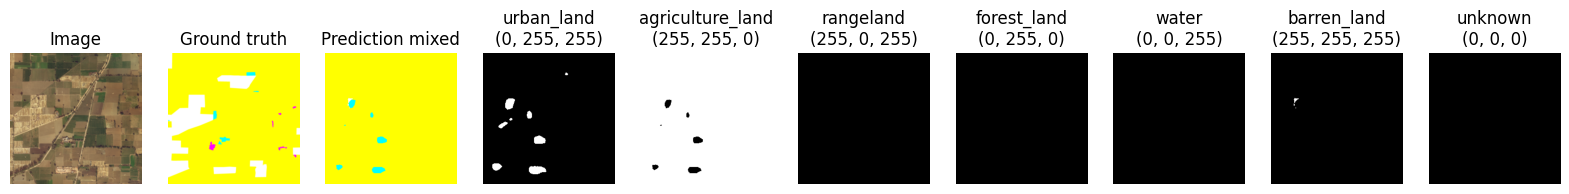

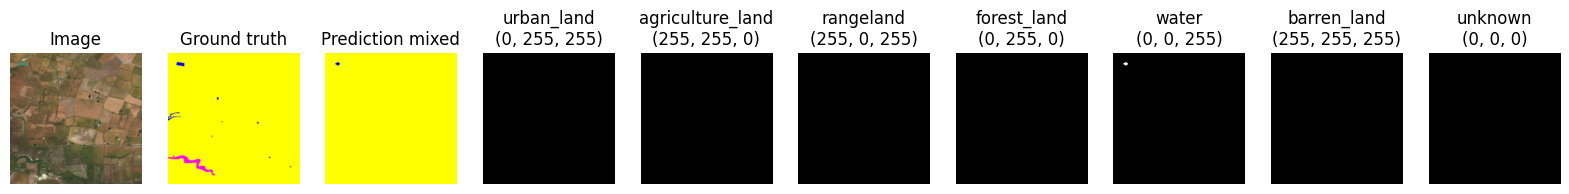

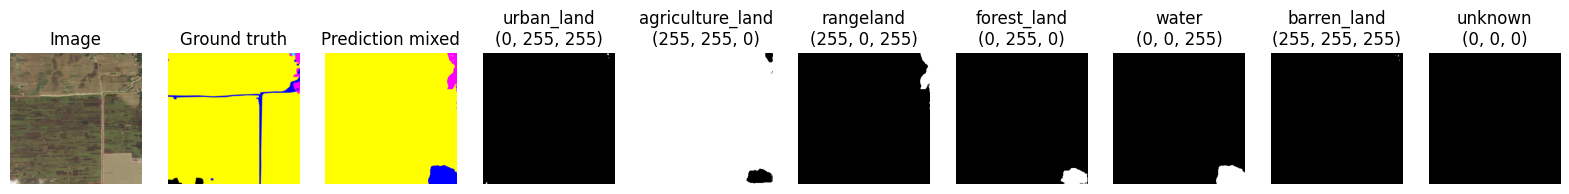

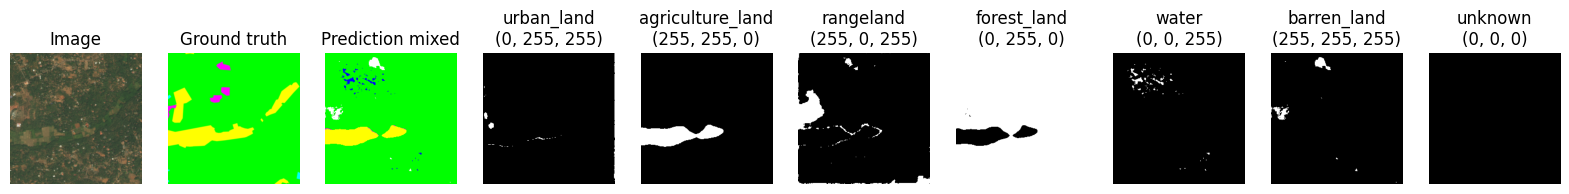

In [28]:
valid_iterator = iter(valid_dataloader)

batch = next(valid_iterator)
batch = next(valid_iterator)

with torch.no_grad():
    model.eval()
    logits = model(batch["image"])

pr_masks = logits.sigmoid()
pr_masks = (pr_masks > 0.5).float()
pr_masks = pr_masks.cpu().numpy()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 10, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 10, 2)
    plt.imshow(gt_mask.numpy().transpose(1, 2, 0)) 
    plt.title("Ground truth")
    plt.axis("off")
    
    image = np.zeros((256, 256, 3), dtype=np.uint8)

    for i in range(7):
        plt.subplot(1, 10, 4+i)
        color = class_dict.loc[i, 'r'], class_dict.loc[i, 'g'], class_dict.loc[i, 'b']
        
        image[pr_mask[i] == 1] = color
        
        plt.imshow(pr_mask[i], cmap='gray')
        plt.title(f"{class_dict.loc[i, 'name']}\n{color}")
        plt.axis("off")

    plt.subplot(1, 10, 3)
    plt.imshow(image)
    plt.title("Prediction mixed")
    plt.axis("off")

    plt.show()